In [7]:
%load_ext autoreload
%autoreload 2

import parse_data.prepare_data as prepare_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import globals
import data_strings
import data_extraction.extract_trial as extract_trial
import utils.cosine_similarity as cosine_similarity
import analysis.wall_visibility_and_choice as wall_visibility_and_choice
import data_extraction.get_indices as get_indices
import plotting.plot_probability_chose_wall as plot_probability_chose_wall

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Notebook to identify opponent visibility at trial start 

In [8]:
data_folder = data_strings.DATA_FOLDER
json_filenames_all_social = data_strings.JSON_FILENAMES_SOCIAL
json_filenames_all_solo = data_strings.JSON_FILENAMES_SOLO

In [9]:
json_filenames = json_filenames_all_social[3]

In [10]:
df, trial_list = prepare_data.prepare_data(data_folder, json_filenames, combine=False)

filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\fourth_experiments_2410\241017\2024-10-17_16-41-38_ZimoElsaSocial.json
Loading complete.
Preprocessing complete.


- Identify opponent position at trial start (so, this must be relative to a player)
- Identify angle to opponent at trial start (as with wall alcoves and sections in trajectory_headangle)
- Identify whether opponent is in field of view at trial start (as with wall visible)
- Filter down the list of trials to only include those in which a wall visility condition was True (either, one wall is visible at slice onset, or both are)
- Using the above as a condition to identify probability of choices (include in or take inspiration from wall_visibility_and_choice)
- extension: also include whether the opponent is facing towards or away from the player (i.e, identify angle of opponent to player at trial start)

Important points: make atomic functions for angle of one player to another, allow easy incorporation of whether opponent in facing player, avoid rewriting
code for conditions and probability. Wall separation should be included in these functions, but may not be used

##### First functions to write:
- Function that takes player id and specified trial and returns the position of the player at trial start (copy from trajectory extraction)
- Function that takes player and 'opponent' position at trial start, and the headangle of the player, and finds the angle from player to opponent (copy from trajectory headangle)
- Umbrella functions to repeat this process throughout a session for a specific player
- Function to filter down the array to only trials that fulfill a certain wall visibility condition (also record trial numbers for easier indexing of the list of 
  pandas dataframes)
- Identification of opponent being within FoV can be done with a boolean operation, no need for a function
- Apply function 2 and boolean operation to get whether player is in FoV of opponent (as a condition for the extension)
- Function to identify whether the choice condition was fulfilled on each of these 
- Function to calculate probability of making a certain choice (parameter) given the trials that fulfill the player and wall visibility condition, using the function to identify the trials that a particular choice was made

In [11]:
def get_player_position_slice_onset(player_id, trial=None, trial_list=None, trial_index=None):
    ''' Return the position of the player at trial start.
        Takes the player_id and a single trial.'''
    
    trial = extract_trial.extract_trial(trial=trial, trial_list=trial_list, trial_index=trial_index)

    # get slice onset index, referenced to trial start
    slice_onset = trial[trial['eventDescription'] == globals.SLICE_ONSET]
    slice_onset_index = slice_onset.index - trial.index[0]
    
    # access the x and y locations stored in the player location dictionary indexed at the current player id
    x_coordinate = trial[globals.PLAYER_LOC_DICT[player_id]['xloc']].iloc[slice_onset_index]
    y_coordinate = trial[globals.PLAYER_LOC_DICT[player_id]['yloc']].iloc[slice_onset_index]

    player_position_coordinates = np.vstack([x_coordinate, y_coordinate])

    return player_position_coordinates


In [12]:
def get_player_headangle_vector_slice_onset(player_id, trial=None, trial_list=None, trial_index=None):
    ''' Return the head angle of the player at trial start.
        Takes the player_id and a single trial. '''
    
    trial = extract_trial.extract_trial(trial, trial_list, trial_index)
    assert isinstance(trial, pd.DataFrame)

    # get slice onset index, referenced to trial start
    slice_onset = trial[trial['eventDescription'] == globals.SLICE_ONSET]
    slice_onset_index = slice_onset.index - trial.index[0]

    # find the euler angle for the rotation around the y (Unity vertical) axis
    y_rotation = trial[globals.PLAYER_ROT_DICT[player_id]['yrot']].iloc[slice_onset_index]
    head_angle = np.deg2rad(y_rotation)
    
    # convert euler angle into euclidean vector
    x_component = np.sin(head_angle)
    z_component = np.cos(head_angle)
    head_angle_vector = np.vstack([x_component, z_component])

    return head_angle_vector



In [13]:
def calculate_vector_norms_for_timepoint(self_other_vector, self_head_angle_vector):
    ''' Return the norm of the head angle vector and the self to other vector
        Returns scalar head_angle_vector_norm and self_to_other_vector_norm '''

    # find norm of headangle vector
    head_angle_vector_norm = np.linalg.norm(self_head_angle_vector)
    
    # find norm of the self-to-other vector
    self_to_other_vector_norm = np.linalg.norm(self_other_vector)

    return head_angle_vector_norm, self_to_other_vector_norm

In [14]:
def calculate_angle_to_opponent_from_positions_and_headangle(self_position, other_position,
                                                                 self_head_angle_vector):
    ''' Use cosine similarity (angle between vectors, length invariant) to return the angle
        between the vector of self head angle and vector from self to other.
        Takes the self position, other position, and self head angle vector. '''

    # calculate euclidean vector from Self to Other
    # self and other position are size 2 vectors (x,y)
    self_other_vector = other_position - self_position

    # dot product between head angle vector and self-other vector
    dot_product_vectors = np.dot(self_other_vector.flatten(), self_head_angle_vector.flatten())

    # vector norms for both self_other_vector and self_head_angle_vector 
    (self_other_vector_norm,
      self_head_angle_vector_norm) = calculate_vector_norms_for_timepoint(self_other_vector, 
                                                                          self_head_angle_vector)
    
    # cosine similarity between the two vectors
    vector_cosine_similarity = cosine_similarity.calculate_cosine_similarity_two_vectors(dot_product_vectors,
                                                                                         self_other_vector_norm,
                                                                                         self_head_angle_vector_norm)
    
    # get angle from cosine similarity
    theta = cosine_similarity.calculate_angle_from_cosine_similarity(vector_cosine_similarity)

    return theta
    



In [15]:
def get_two_player_positions_slice_onset(player_id, trial=None, trial_list=None, trial_index=None):
    ''' Return the Self position and Other position for a trial, at slice onset'''

    opponent_id = 1 if player_id == 0 else 0

    self_position = get_player_position_slice_onset(player_id, trial, trial_list, trial_index)

    other_position = get_player_position_slice_onset(opponent_id, trial, trial_list, trial_index)

    return self_position, other_position

In [16]:
# Umbrella function to find trial start angle identification for a single player for one trial
def get_angle_of_opponent_from_player_trial(player_id, trial=None, trial_list=None, trial_index=None):
    ''' For a single trial, return the angle from player head direction to opponent player.
        Takes the player_id of Self, and the trial. '''

    # find self and other positions 
    self_position, other_position = get_two_player_positions_slice_onset(player_id, trial=trial,
                                                                        trial_list=trial_list,
                                                                        trial_index=trial_index)

    # find general self head angle vector
    self_head_angle_vector = get_player_headangle_vector_slice_onset(player_id, trial=trial,
                                                                    trial_list=trial_list,
                                                                    trial_index=trial_index)

    # calculate angle from cosine similarity between self_head_angle_vector and self_to_other vector
    # (self_to_other_vector is calculated in this function as the difference between Self and Other position)
    theta = calculate_angle_to_opponent_from_positions_and_headangle(self_position,
                                                                    other_position,
                                                                    self_head_angle_vector)
  
    return theta
    

In [17]:
# Umbrella function to repeat trial start angle identification for a single player for one session
# THIS IS THE MAIN UMBRELLA FUNCTION FOR SESSION USE

def get_angle_of_opponent_from_player_session(player_id, trial_list):
    ''' For all trials in a session, return the angle from player head direction to opponent player.
        Takes the player_id of Self (persistent throughout session) and the trial list. '''
    
    # get the angle for each trial in session, for a persistent Self player_id
    orientation_angle_to_other_session = np.full(len(trial_list), np.nan,  dtype=float)
    for i, trial in enumerate(trial_list):
    
        theta = get_angle_of_opponent_from_player_trial(player_id, trial=trial)

        orientation_angle_to_other_session[i] = theta

    return orientation_angle_to_other_session
    

In [18]:
def get_other_visible_session(orientation_angle_to_other_session, current_fov):
    ''' Return a boolean array for whether Other is visible to Self at trials start.
        Takes the angle of orientation from self to other as an array for the session (in radians)
        and the visible fov for this dataset (in degrees) '''

    # convert orientation_angle_to_other_session from radians to degrees to match current_fov
    orientation_angle_to_other_session = np.rad2deg(orientation_angle_to_other_session)

    # if Other is visible, the angle to orient Other into Self central view must be less than half the current
    # field-of-view.
    # At the threshold, Other enters visual periphery
    other_visible_session = orientation_angle_to_other_session < current_fov/2

    return other_visible_session


In [19]:
def filter_trials_other_visible(trial_list, other_visible_session, inverse=False):
    ''' Return a filtered trial list and list of indices from the original trial list that
        conform to Other visible to player player_id at trial start.
        If inverse=True, return only trials where Other is not visible '''
    
    if not inverse:
        other_visible_trial_indices = np.where(other_visible_session == True)
    else:
        other_visible_trial_indices = np.where(other_visible_session == False)
    
    # index the tuple and allow list-compatible indexing
    other_visible_trial_indices = other_visible_trial_indices[0].tolist() 

    # Use a list comprehension to index the trial list with the indices list
    trial_list_filtered = [trial_list[i] for i in other_visible_trial_indices]

    return trial_list_filtered, other_visible_trial_indices
    
    

In [20]:
def filter_trials_retrievable_choice(trial_list, player_id, inferred_choice):
    ''' Return the filtered trial list and list of indices from the original trial list that
        conform with player player_id having a recorded choice.
        This is required for accurate probabilities, because we do cannot include trials (as negative)
        where we do not know what the player's choice would have been. '''
    
    # get player choice (wall number) for each trial
    # inferred choice can be used here
    player_choice = wall_visibility_and_choice.get_player_wall_choice(trial_list, player_id,
                                                                        inferred_choice, debug=False)
    
    print(f"player_choice, inferred status {inferred_choice} is:\n{player_choice}")
    
    # filter trials list to only include trials where this player had a recorded choice
    player_recorded_choice_indices = np.where(~np.isnan(player_choice))

    # index the tuple and allow list-compatible indexing
    player_recorded_choice_indices = player_recorded_choice_indices[0].tolist()

    # Use a list comprehension to index the trial list with the indices list
    trial_list_filtered = [trial_list[i] for i in player_recorded_choice_indices]

    return trial_list_filtered, player_recorded_choice_indices

    

In [21]:
def filter_trials_one_wall_initially_visible(trial_list, player_id, wall_index):
    ''' Return a filtered trial list and list of indices from the original trial list that
        conform to a single trial wall being visible to player player_id at trial start,
        conferred by wall_index (e.g. 0 or 1 for wall1 or wall2) '''
    
    # find wall visibility for the full session
    (wall1_visible_session,
    wall2_visible_session) = wall_visibility_and_choice.get_walls_initial_visibility_session(trial_list=trial_list,
                                                                    player_id=player_id,
                                                                    debug=False, current_fov=110)
    
    if wall_index == 0:
        single_wall_visible_indices = np.where((wall1_visible_session == True) & (wall2_visible_session == False))
    elif wall_index == 1:
        single_wall_visible_indices = np.where((wall2_visible_session == True) & (wall1_visible_session == False))

    # index the tuple and allow list-compatible indexing
    single_wall_visible_indices = single_wall_visible_indices[0].tolist() 

    trial_list_filtered = [trial_list[i] for i in single_wall_visible_indices]

    return trial_list_filtered, single_wall_visible_indices


In [22]:
def filter_trials_both_walls_initially_visible(trial_list, player_id):
    ''' Return a filtered trial list and list of indices from the original trial list that
        conform to both trial walls being visible to player player_id at trial start. '''
    
    # find wall visibility for the full session
    (wall1_visible_session,
    wall2_visible_session) = wall_visibility_and_choice.get_walls_initial_visibility_session(trial_list=trial_list,
                                                                    player_id=player_id,
                                                                    debug=False, current_fov=110)
    

    both_walls_visible_indices = np.where((wall1_visible_session == True) & (wall2_visible_session == True))
    
    # index the tuple and allow list-compatible indexing
    both_walls_visible_indices = both_walls_visible_indices[0].tolist() 

    # Use a list comprehension to index the trial list with the indices list
    trial_list_filtered = [trial_list[i] for i in both_walls_visible_indices]

    return trial_list_filtered, both_walls_visible_indices

In [23]:
# filter trial list further with visibility of Other

# then, work out which trials the player made a certain choice (choose High), use wall_visibility_and_choice

# calculate the basic probability

# (keep in mind being able to include Other visibility of Self)

For probability, we want:
- denominator: number of trials that a player made a wall choice (under condition Other visible)
- numerator: Number of trials of the denominator where the player chose equal to High

currently we have instead: 
- denominator: number of ALL trials total (under condition Other visible)
- numerator: Number of trials of the denominator where player chose equal to High (without accounting for whether player choice can be retrieved/was winner, etc.)

Need to change denominator to only trials with retrievable choice for player_id

Need to change numerator to then be from the same batch

In [24]:
def filter_trials_player_chose_given_wall(trial_list, player_id, inferred_choice=False, given_wall_index=0):
    ''' Return a filtered trial list and list of indices from the original trial list 
        where player choice (winner + loser, or just winner) aligned with
        the given wall index (e.g., 0 for wall1) '''
    
    # get player choice (wall number) for each trial
    # inferred choice can be used here
    player_choice = wall_visibility_and_choice.get_player_wall_choice(trial_list, player_id,
                                                                        inferred_choice, debug=False)
    
    print(f"player choice array:\n{player_choice}")

    # get the truth array for whether the player choice wall aligns with the given wall parameter
    given_wall_chosen_session = get_indices.was_given_wall_chosen(trial_list, player_choice,
                                                                  given_wall_index)
    
    print(f"given wall chosen array:\n{given_wall_chosen_session}")
    
    # find the indices of the trials in trial_list where the given wall was chosen by player player_id
    given_wall_chosen_indices = np.where(given_wall_chosen_session == True)
    print(f"given wall chosen true indices:\n{given_wall_chosen_indices}")
    
    # index the tuple and allow list-compatible indexing
    given_wall_chosen_indices = given_wall_chosen_indices[0].tolist()

    # Use a list comprehension to index the trial list with the indices list
    trial_list_filtered = [trial_list[i] for i in given_wall_chosen_indices]

    # return filtered trial_list, and list of indices with which to index the original list
    return trial_list_filtered, given_wall_chosen_indices
    


In [25]:
def calculate_probability_choose_wall(trial_list, trial_list_choice_filtered):
    ''' Given a trial list (pre-filtered, but not for choice), calculate the probability that 
        a player will choose a given wall value as the proportion of trials from the trial
        list in which the player chose the wall value.
        More complex use of this function could involve e.g. filtering the trial list for 
        trials where Low was first seen and the Opponent is visible, and then further filtering
        for player choice being 'Low', to find probability of (choose Low | first visible) under the
        condition of Other visibility at trial start. '''
        
    
    # use the length of the trial list pre-choice filtering, and the length of the trial list post-choice
    # filtering (e.g. with filter_trials_player_chose_given_wall) to calculate the proportion of 
    # relevant trials that a player chose a specific wall
    try:
        probability_chose_wall = len(trial_list_choice_filtered)/len(trial_list)
    except ZeroDivisionError:
        probability_chose_wall = np.nan

    return probability_chose_wall
    
    

### Sandbox-y

In [32]:
wall_sep=None
trial_type = globals.HIGH_LOW
player_id = 0


In [30]:
# filter the trial list for trialtype and wallsep

# filter trial list for HighLow trialtype
trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
trial_list_filtered = [trial_list[i] for i in trial_indices]

# filter trial list for wall separations if specified
if wall_sep:
    trial_indices = get_indices.get_trials_with_wall_sep(trial_list_filtered, wall_sep=wall_sep)
    trial_list_filtered = [trial_list_filtered[i] for i in trial_indices]


In [31]:
trial_list_one = [trial_list_filtered[0]]
sandbox_trial_list = trial_list_filtered

In [260]:
head_angle_vector = get_player_headangle_vector_slice_onset(player_id, trial_list=sandbox_trial_list, trial_index=0)
head_angle_vector

array([[-0.38454914],
       [ 0.92310452]])

In [261]:
self_position, other_position = get_two_player_positions_slice_onset(player_id, trial_list=sandbox_trial_list, trial_index=0)
self_position, other_position

(array([[1.18000007],
        [0.        ]]),
 array([[1.50555205],
        [1.2378962 ]]))

In [262]:
orientation_angle_to_other_session = get_angle_of_opponent_from_player_session(player_id, sandbox_trial_list)
np.rad2deg(orientation_angle_to_other_session)

array([ 37.35021789,  54.72790746,   9.28596822, 158.04598611,
       136.67858989,  22.8537495 ,  44.94825566,  42.53329517,
       149.3236798 , 112.45462381, 148.31612798,  20.35347853,
        33.86543548, 143.70145699,  89.16332914,   6.79913893,
        85.64387268,  70.94987251,  31.54975424,  31.90981187,
         6.90464665,  73.04375472,  84.5440001 , 124.35419168,
       104.65727621,  51.07209183, 129.3780313 , 173.18688427,
        44.83891536,  19.22186391,  13.53849471, 109.87667343,
         6.33488318,  90.81981646, 143.77141384, 120.46447565,
       127.17938918,  99.50725738,  93.20075712,  89.56806717,
        76.0560785 , 175.6802073 ,  55.28440407,  65.78230616,
        85.21736668,  15.16389511,  87.87495147,  34.04464451,
         6.33769394,   3.26082411,  31.79057428, 131.12483473,
        80.40413745,  44.52585687,  41.14287831,  50.13530453,
        62.56376928,  40.34604198, 175.56220929, 133.75923865,
       139.62841947, 133.01811831, 170.44685904,  22.99

In [264]:
other_visible_session = get_other_visible_session(orientation_angle_to_other_session, current_fov=110)
other_visible_session

array([ True,  True,  True, False, False,  True,  True,  True, False,
       False, False,  True,  True, False, False,  True, False, False,
        True,  True,  True, False, False, False, False,  True, False,
       False,  True,  True,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False,  True,  True,  True,  True, False, False,  True,
        True,  True, False,  True, False, False, False, False, False,
        True,  True, False,  True, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False,  True, False, False,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
        True, False, False, False,  True, False, False, False, False,
       False, False, False,  True,  True,  True, False, False,  True,
       False, False,

Walking through the process for getting P(Choose High) for trials where the opponent is visible and High is first seen

In [288]:
# filter Other initially visible
(trial_list_filtered_other_visible,
  other_visible_trial_indices) = filter_trials_other_visible(sandbox_trial_list, other_visible_session)
len(other_visible_trial_indices)

44

In [306]:
# filter both walls initially visible
(trial_list_filtered_both_walls_visible,
  both_walls_visible_indices) = filter_trials_both_walls_initially_visible(trial_list_filtered_other_visible, player_id)
both_walls_visible_indices

[10, 11, 16, 20, 23, 30, 37, 43]

In [305]:
# filter high wall initially visible
(trial_list_filtered_high_wall_initially_visible,
  high_wall_initially_visible_indices) = filter_trials_one_wall_initially_visible(trial_list_filtered_other_visible, player_id, wall_index=0)
len(high_wall_initially_visible_indices)

13

In [307]:
(trial_list_filtered_player_choice,
  player_chose_given_wall_indices) = filter_trials_player_chose_given_wall(trial_list_filtered_high_wall_initially_visible, player_id,
                                                                            inferred_choice=True, given_wall_index=0)
len(player_chose_given_wall_indices)

6

In [279]:
# test the player choice function is working correctly

player_choice = wall_visibility_and_choice.get_player_wall_choice(sandbox_trial_list, player_id,
                                                                    inferred_choice=False, debug=False)

high_wall = np.full(len(sandbox_trial_list), np.nan)
for i, trial in enumerate(sandbox_trial_list):
    high_wall[i] = get_indices.get_walls(trial)[0]

player_choice, high_wall

(array([nan,  1., nan,  3.,  2., nan,  3.,  6., nan, nan,  6., nan, nan,
        nan, nan, nan,  4., nan,  8., nan, nan, nan,  8.,  6., nan, nan,
         8., nan,  3.,  5., nan, nan, nan,  8.,  8.,  6., nan, nan, nan,
         6., nan,  4., nan, nan, nan, nan,  3.,  3., nan, nan, nan, nan,
         1., nan,  3., nan, nan, nan, nan,  6.,  5.,  4., nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan,  4., nan, nan,  4., nan, nan,  6.,  5., nan, nan,  5., nan,
        nan, nan, nan, nan, nan, nan,  5., nan,  5., nan,  3.,  4.,  4.,
        nan, nan,  7., nan, nan, nan, nan,  1.,  6.,  1., nan,  2.,  8.,
        nan, nan, nan,  8., nan, nan, nan, nan, nan, nan,  8., nan, nan,
        nan, nan,  1., nan, nan, nan]),
 array([5., 1., 3., 3., 2., 7., 3., 6., 8., 1., 7., 1., 1., 6., 2., 7., 8.,
        2., 8., 4., 5., 8., 8., 2., 2., 2., 8., 4., 7., 5., 4., 4., 6., 8.,
        8., 6., 6., 8., 3., 5., 7., 8., 4., 8., 5., 7., 3., 1., 4., 3., 1.,
  

In [308]:
probability_chose_wall = calculate_probability_choose_wall(trial_list_filtered_high_wall_initially_visible, trial_list_filtered_player_choice)
probability_chose_wall

0.46153846153846156

In [40]:
# umbrella function to compare probabilities of P(High | first visible) between Other visible and Other not visible

def probability_chose_wall_conditioned_on_wall_and_other_visibility(trial_list, other_visible_session, player_id=0, visible_wall_index=0,
                 chosen_wall_index=0, inferred_choice=True, inverse_other_visible=False):
    
    # filter Other initially visible
    (trial_list_filtered_other_visible,
    other_visible_trial_indices) = filter_trials_other_visible(trial_list, other_visible_session,
                                                               inverse=inverse_other_visible)
    print(f"Len other_visible_trial_indices: {len(other_visible_trial_indices)}")

    # filter trials with a retrievable choice for this player (trials only valid for analysis if we 
    # have a recorded choice for the player)
    (trial_list_filtered_player_choice_exists,
    player_choice_exists_indices) = filter_trials_retrievable_choice(trial_list_filtered_other_visible, player_id, inferred_choice)
    print(f"Len player_choice_exists_indices: {len(player_choice_exists_indices)}")

    # filter Other initially visible with high wall initially visible
    (trial_list_filtered_high_wall_initially_visible,
    high_wall_initially_visible_indices) = filter_trials_one_wall_initially_visible(trial_list_filtered_player_choice_exists, player_id,
                                                                                     wall_index=visible_wall_index)
    print(f"Len high_wall_initially_visible_indinces: {len(high_wall_initially_visible_indices)}")

    # filter Other-visible, High initially visible, with player_choice aligning with given wall (given_wall_index)
    (trial_list_filtered_player_choice,
    player_chose_given_wall_indices) = filter_trials_player_chose_given_wall(trial_list_filtered_high_wall_initially_visible, player_id,
                                                                                inferred_choice,
                                                                                  given_wall_index=chosen_wall_index)
    print(f"Len player_chose_given_wall_indices: {len(player_chose_given_wall_indices)}")

    # find the probability of the player choosing the given wall index, considering only trials that are filtered for 
    # Other visibility and initial wall visibility
    probability_chose_wall = calculate_probability_choose_wall(trial_list_filtered_high_wall_initially_visible, trial_list_filtered_player_choice)

    return probability_chose_wall

    

In [35]:
# umbrella function to compare probabilities of P(High) between Other visible and Other not visible

def probability_chose_wall_conditioned_on_other_visibility(trial_list, other_visible_session, player_id=0,
                 chosen_wall_index=0, inferred_choice=False, inverse_other_visible=False):
    
    
    # filter Other initially visible
    (trial_list_filtered_other_visible,
    other_visible_trial_indices) = filter_trials_other_visible(trial_list, other_visible_session,
                                                               inverse=inverse_other_visible)
    print(f"Len other_visible_trial_indices: {len(other_visible_trial_indices)}")
    
    # filter trials with a retrievable choice for this player (trials only valid for analysis if we 
    # have a recorded choice for the player)
    (trial_list_filtered_player_choice_exists,
    player_choice_exists_indices) = filter_trials_retrievable_choice(trial_list_filtered_other_visible, player_id, inferred_choice)
    print(f"Len player_choice_exists_indices: {len(player_choice_exists_indices)}")
    

    # filter Other-visible with player_choice aligning with given wall (given_wall_index)
    (trial_list_filtered_player_choice,
    player_chose_given_wall_indices) = filter_trials_player_chose_given_wall(trial_list_filtered_player_choice_exists, player_id,
                                                                                inferred_choice,
                                                                                  given_wall_index=chosen_wall_index)
    print(f"Len player_chose_given_wall_indices: {len(player_chose_given_wall_indices)}")

    # find the probability of the player choosing the given wall index, considering only trials that are filtered for 
    # Other visibility and initial wall visibility
    probability_chose_wall = calculate_probability_choose_wall(trial_list_filtered_player_choice_exists, trial_list_filtered_player_choice)

    return probability_chose_wall 

In [45]:
# umbrella function to compare probabilities of winning between Other visible and Other not visible

def probability_win_trial_conditioned_on_other_visibility(trial_list, other_visible_session, player_id=0,
                 inverse_other_visible=False):
    
    
    # filter Other initially visible
    (trial_list_filtered_other_visible,
    other_visible_trial_indices) = filter_trials_other_visible(trial_list, other_visible_session,
                                                               inverse=inverse_other_visible)
    print(f"Len other_visible_trial_indices: {len(other_visible_trial_indices)}")
    
    # # filter trials with a retrievable choice for this player (trials only valid for analysis if we 
    # # have a recorded choice for the player)
    # (trial_list_filtered_player_choice_exists,
    # player_choice_exists_indices) = filter_trials_retrievable_choice(trial_list_filtered_other_visible, player_id, inferred_choice)
    # print(f"Len player_choice_exists_indices: {len(player_choice_exists_indices)}")
    

    # filter Other-visible with player being the winner
    trigger_activators = get_indices.get_trigger_activators(trial_list_filtered_other_visible)
    this_player_wins_indices = np.where(trigger_activators == player_id)
    # index the tuple and allow list-compatible indexing
    this_player_wins_indices = this_player_wins_indices[0].tolist() 
    # Use a list comprehension to index the trial list with the indices list
    trial_list_filtered_this_player_wins = [trial_list_filtered_other_visible[i] for i in this_player_wins_indices]
    print(f"Len trial_list_filtered_this_player_wins: {len(trial_list_filtered_this_player_wins)}")

    # find the probability of the player choosing the given wall index, considering only trials that are filtered for 
    # Other visibility and initial wall visibility
    probability_chose_wall = calculate_probability_choose_wall(trial_list_filtered_other_visible, trial_list_filtered_this_player_wins)

    return probability_chose_wall 

In [ ]:
a = probability_chose_wall_conditioned_on_wall_and_other_visibility(sandbox_trial_list, other_visible_session,
                                                                     inverse_other_visible=False)
b = probability_chose_wall_conditioned_on_wall_and_other_visibility(sandbox_trial_list, other_visible_session,
                                                                     inverse_other_visible=True)
wall_choice_probabilities = np.array([a,b])

Len other_visible_trial_indices: 44
Len high_wall_initially_visible_indinces: 13
Len player_chose_given_wall_indices: 6
Len other_visible_trial_indices: 92
Len high_wall_initially_visible_indinces: 24
Len player_chose_given_wall_indices: 22


d:\tom\documents\swc\repos\octagon_analysis\plotting\plot_probability_chose_wall.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Condition", y="Probability", data=df, palette="Paired", width=.8)


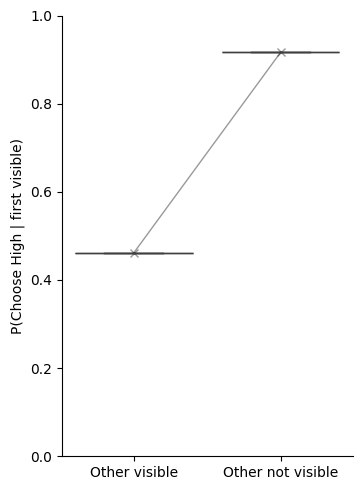

In [328]:
plot_probability_chose_wall.boxplot_probability_choose_wall(wall_choice_probabilities, ['Other visible', 'Other not visible'], ylabel="P(Choose High | first visible)")

In [27]:
# repeat for all datasets
df_all, trial_list_all = prepare_data.prepare_data(data_folder, json_filenames_all_social, combine=False) 

filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\first_experiments_2409\240913\2024-09-13_11-31-00_YansuJerrySocial.json
Data is from period before 2024-09-13 00:00:00
Running dataframe through playerinfo_playerposition_conversion.
Loading complete.
Preprocessing complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\second_experiments_2409\240927\2024-09-27_14-25-20_SaraEmilySocial.json
Loading complete.
Preprocessing complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\third_experiments_2410\241017\2024-10-17_14-28-40_ShamirAbigailSocial.json
Loading complete.
Preprocessing complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\fourth_experiments_2410\241017\2024-10-17_16-41-38_ZimoElsaSocial.json
Loading complete.
Preprocessing complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\fifth_experiments_241112\2024-11-12_13-31-14_KhadijaWendySocial.json
Loading complete.
Preprocessing complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\sixth_experiments_241112\2024-11-12_15-23-24_Franc

In [355]:
bb

array([0.76923077, 0.66666667, 0.75      , 0.91666667, 0.66666667,
       1.        , 1.        , 0.77777778, 0.52631579, 0.92857143,
       1.        , 0.58333333, 1.        , 0.88235294, 0.76190476,
       0.77272727, 0.71428571,        nan])

In [ ]:
aaa = np.full(len(trial_list_all), np.nan)
bbb = np.full(len(trial_list_all), np.nan)

for i, trial_list in enumerate(trial_list_all):

    # filter trial list for HighLow trialtype
    trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
    trial_list_filtered = [trial_list[i] for i in trial_indices]

    player_id = 1
    # get Other visibility for this trial list
    orientation_angle_to_other_session = get_angle_of_opponent_from_player_session(player_id, trial_list_filtered)
    other_visible_session = get_other_visible_session(orientation_angle_to_other_session, current_fov=110)
    
    aaa[i] = probability_chose_wall_conditioned_on_wall_and_other_visibility(trial_list_filtered, other_visible_session,
                                                                        inverse_other_visible=False)
    bbb[i] = probability_chose_wall_conditioned_on_wall_and_other_visibility(trial_list_filtered, other_visible_session,
                                                                     inverse_other_visible=True)
    
wall_choice_probabilities = [aaa,bbb]

In [365]:
bb

array([0.76923077, 0.66666667, 0.75      , 0.91666667, 0.66666667,
       1.        , 1.        , 0.77777778, 0.52631579, 0.92857143,
       1.        , 0.58333333, 1.        , 0.88235294, 0.76190476,
       0.77272727, 0.71428571,        nan])

In [ ]:
aa = np.full(len(trial_list_all), np.nan)
bb = np.full(len(trial_list_all), np.nan)

for i, trial_list in enumerate(trial_list_all):

    # filter trial list for HighLow trialtype
    trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
    trial_list_filtered = [trial_list[i] for i in trial_indices]

    player_id = 0
    # get Other visibility for this trial list
    orientation_angle_to_other_session = get_angle_of_opponent_from_player_session(player_id, trial_list_filtered)
    other_visible_session = get_other_visible_session(orientation_angle_to_other_session, current_fov=110)
    
    aa[i] = probability_chose_wall_conditioned_on_wall_and_other_visibility(trial_list_filtered, other_visible_session,
                                                                        inverse_other_visible=False)
    bb[i] = probability_chose_wall_conditioned_on_wall_and_other_visibility(trial_list_filtered, other_visible_session,
                                                                     inverse_other_visible=True)
    
wall_choice_probabilities = [aa,bb]

In [ ]:
a = np.full(len(trial_list_all)*2, np.nan)
b = np.full(len(trial_list_all)*2, np.nan)
trial_list_index = 0
inferred_choice=False

for i in range(0,len(trial_list_all)*2, 2):

    trial_list = trial_list_all[trial_list_index]

    # filter trial list for HighLow trialtype
    trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
    trial_list_filtered = [trial_list[i] for i in trial_indices]

    player_id = 0
    # get Other visibility for this trial list
    orientation_angle_to_other_session = get_angle_of_opponent_from_player_session(player_id, trial_list_filtered)
    other_visible_session = get_other_visible_session(orientation_angle_to_other_session, current_fov=110)
    
    a[i] = probability_chose_wall_conditioned_on_wall_and_other_visibility(trial_list_filtered, other_visible_session,
                                                                        inferred_choice, inverse_other_visible=False)
    b[i] = probability_chose_wall_conditioned_on_wall_and_other_visibility(trial_list_filtered, other_visible_session,
                                                                     inferred_choice, inverse_other_visible=True)
    
    player_id = 1
    # get Other visibility for this trial list
    orientation_angle_to_other_session = get_angle_of_opponent_from_player_session(player_id, trial_list_filtered)
    other_visible_session = get_other_visible_session(orientation_angle_to_other_session, current_fov=110)
    
    a[i+1] = probability_chose_wall_conditioned_on_wall_and_other_visibility(trial_list_filtered, other_visible_session,
                                                                        inferred_choice, inverse_other_visible=False)
    b[i+1] = probability_chose_wall_conditioned_on_wall_and_other_visibility(trial_list_filtered, other_visible_session,
                                                                     inferred_choice, inverse_other_visible=True)
    
    trial_list_index += 1
    
    
wall_choice_probabilities = [a,b]

In [38]:
c = np.full(len(trial_list_all)*2, np.nan)
d = np.full(len(trial_list_all)*2, np.nan)
trial_list_index = 0
inferred_choice=True

for i in range(0,len(trial_list_all)*2, 2):

    trial_list = trial_list_all[trial_list_index]

    # filter trial list for HighLow trialtype
    trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
    trial_list_filtered = [trial_list[i] for i in trial_indices]

    player_id = 0
    # get Other visibility for this trial list
    orientation_angle_to_other_session = get_angle_of_opponent_from_player_session(player_id, trial_list_filtered)
    other_visible_session = get_other_visible_session(orientation_angle_to_other_session, current_fov=110)
    
    c[i] = probability_chose_wall_conditioned_on_other_visibility(trial_list_filtered, other_visible_session,
                                                                  inferred_choice, inverse_other_visible=False)
    d[i] = probability_chose_wall_conditioned_on_other_visibility(trial_list_filtered, other_visible_session,
                                                                  inferred_choice, inverse_other_visible=True)
    
    player_id = 1
    # get Other visibility for this trial list
    orientation_angle_to_other_session = get_angle_of_opponent_from_player_session(player_id, trial_list_filtered)
    other_visible_session = get_other_visible_session(orientation_angle_to_other_session, current_fov=110)
    
    c[i+1] = probability_chose_wall_conditioned_on_other_visibility(trial_list_filtered, other_visible_session,
                                                                    inferred_choice, inverse_other_visible=False)
    d[i+1] = probability_chose_wall_conditioned_on_other_visibility(trial_list_filtered, other_visible_session,
                                                                    inferred_choice, inverse_other_visible=True)
    
    trial_list_index += 1
    
    
wall_choice_probabilities2 = [c,d]


Len other_visible_trial_indices: 44
player_choice, inferred status False is:
[ 2. nan nan  4.  3. nan  8.  3. nan  3. nan  8. nan nan nan  1. nan  2.
  8.  2.  7.  3. nan nan  4.  8. nan nan nan  2.  6.  7. nan nan nan  3.
  3.  1.  2.  8.  1.  1. nan  4.]
Len player_choice_exists_indices: 26
player choice array:
[2. 4. 3. 8. 3. 3. 8. 1. 2. 8. 2. 7. 3. 4. 8. 2. 6. 7. 3. 3. 1. 2. 8. 1.
 1. 4.]
given wall chosen array:
[1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0.
 0. 1.]
given wall chosen true indices:
(array([ 0,  1,  2,  6,  7,  8, 10, 11, 12, 13, 15, 16, 18, 19, 21, 25]),)
Len player_chose_given_wall_indices: 16
Len other_visible_trial_indices: 58
player_choice, inferred status False is:
[nan nan  8.  4.  5.  4.  3. nan  4.  3. nan  5. nan  5. nan nan nan nan
  6. nan  4.  2.  5.  4.  3. nan  1. nan nan  1. nan nan nan  6.  2.  4.
 nan  5. nan  6. nan nan  4.  7. nan  5. nan  7.  1.  2.  7. nan nan  1.
  4.  2.  2. nan]
Len player_choice_exists_indices: 33


In [383]:
d

array([0.4137931 , 0.43589744, 0.31944444, 0.34693878, 0.48214286,
       0.59649123, 0.38043478, 0.34831461, 0.26086957, 0.25454545,
       0.71428571, 0.72      , 0.55072464, 0.60606061, 0.51388889,
       0.5       , 0.42028986, 0.36923077, 0.69230769, 0.60377358,
       0.39705882, 0.36111111, 0.35443038, 0.36708861, 0.64      ,
       0.62903226, 0.75384615, 0.66666667, 0.45      , 0.44927536,
       0.57831325, 0.51948052, 0.45121951, 0.47727273, 0.25      ,
       0.35      ])

In [ ]:
e = np.full(len(trial_list_all)*2, np.nan)
f = np.full(len(trial_list_all)*2, np.nan)
trial_list_index = 0

for i in range(0,len(trial_list_all)*2, 2):

    trial_list = trial_list_all[trial_list_index]

    # filter trial list for HighLow trialtype
    trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
    trial_list_filtered = [trial_list[i] for i in trial_indices]

    player_id = 0
    # get Other visibility for this trial list
    orientation_angle_to_other_session = get_angle_of_opponent_from_player_session(player_id, trial_list_filtered)
    other_visible_session = get_other_visible_session(orientation_angle_to_other_session, current_fov=110)
    
    e[i] = probability_win_trial_conditioned_on_other_visibility(trial_list_filtered, other_visible_session,
                                                                   inverse_other_visible=False)
    f[i] = probability_win_trial_conditioned_on_other_visibility(trial_list_filtered, other_visible_session,
                                                                   inverse_other_visible=True)
    
    player_id = 1
    # get Other visibility for this trial list
    orientation_angle_to_other_session = get_angle_of_opponent_from_player_session(player_id, trial_list_filtered)
    other_visible_session = get_other_visible_session(orientation_angle_to_other_session, current_fov=110)
    
    e[i+1] = probability_win_trial_conditioned_on_other_visibility(trial_list_filtered, other_visible_session,
                                                                     inverse_other_visible=False)
    f[i+1] = probability_win_trial_conditioned_on_other_visibility(trial_list_filtered, other_visible_session,
                                                                     inverse_other_visible=True)
    
    trial_list_index += 1
    
    
wall_choice_probabilities3 = [e,df]


d:\tom\documents\swc\repos\octagon_analysis\plotting\plot_probability_chose_wall.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Condition", y="Probability", data=df, palette="Paired", width=.8)


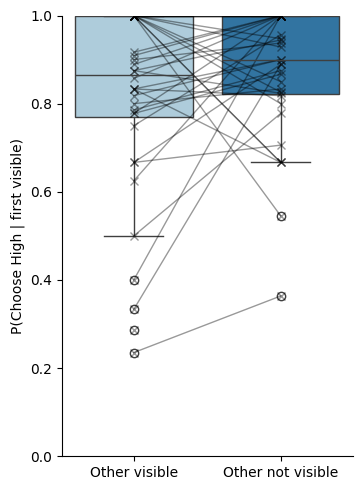

In [53]:
plot_probability_chose_wall.boxplot_probability_choose_wall(wall_choice_probabilities, ['Other visible', 'Other not visible'], ylabel="P(Choose High | first visible)")

d:\tom\documents\swc\repos\octagon_analysis\plotting\plot_probability_chose_wall.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Condition", y="Probability", data=df, palette="Paired", width=.8)


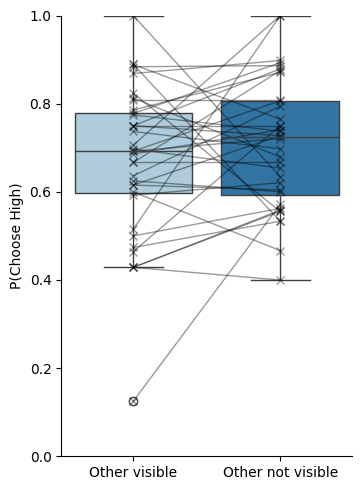

In [51]:
plot_probability_chose_wall.boxplot_probability_choose_wall(wall_choice_probabilities2, ['Other visible', 'Other not visible'], ylabel="P(Choose High)")

In [52]:
# Check the above plot. It doesn't make much sense to me that P(choose High) is so low in social here